# Notebook Version 2

I made a condensed, and more flexible notebook from out initial. It contains the same processing, but not ass much intermittent reporting making navigation easier. One can of course add code where additional summary reports or graphics is needed. In addition, if the functions generating these reports are in a separate file, this notebook can stay condensed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency



In [2]:
from helpers import outliers_IQR, outliers_z_score, outliers_min_max, handle_outliers, fix_obesity

In [3]:
diabetes = pd.read_csv('diabetes.csv')

binary_features = ['Obesity', 'TCep', 'Polydipsia', 'Sudden Weight Loss', 'Weakness',
                   'Polyphagia', 'Genital Thrush', 'Visual Blurring', 'Itching',
                   'Irritability', 'Delayed Healing', 'Partial Paresis', 'Muscle Stiffness', 'Alopecia']
cat_features = ['Race',	'Occupation',	'GP']
num_features = ['Age',	'Height',	'Weight',	'Temperature',	'Urination']
one_hot_features = {} # for future use
diabetes.info()
print("Found:", len(cat_features+binary_features+num_features)+1) # +1 for Gender
print("In DS:", diabetes.shape[1]-1) # -1 for target


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 534 non-null    float64
 1   Gender              542 non-null    object 
 2   Race                537 non-null    object 
 3   Occupation          534 non-null    object 
 4   GP                  539 non-null    object 
 5   Height              538 non-null    float64
 6   Weight              541 non-null    float64
 7   Obesity             538 non-null    object 
 8   Temperature         546 non-null    float64
 9   Urination           532 non-null    float64
 10  TCep                546 non-null    object 
 11  Polydipsia          540 non-null    object 
 12  Sudden Weight Loss  530 non-null    object 
 13  Weakness            541 non-null    object 
 14  Polyphagia          544 non-null    object 
 15  Genital Thrush      538 non-null    object 
 16  Visual B

## Uniform formatting

In [4]:

# Converts all binary features to lower case
for f in binary_features:
   diabetes[f] = diabetes[f].str.lower()

# Converts all binary features to ints, preserving Na-s
diabetes = diabetes.replace({'yes':1, 'no':0}) 
diabetes = diabetes.replace({'Positive':1, 'Negative':0}) 

## Duplicates

We identify duplicates and delete them. We assume they are caused by an error in the data collection, and it's unlikely that there are two correct instances with the exact same values.  



In [5]:
diabetes = diabetes.drop_duplicates(keep='first')

# Summary reports

# Preliminary Data analysis

# Train - Test split
We split as early as possible to avoid cross contamination of information from the test set.

In [6]:
train_proportion = 0.8
train_idx = np.random.choice(diabetes.index, int(train_proportion*len(diabetes.index)), replace=False)
train = diabetes.loc[train_idx]
test = diabetes.drop(train_idx)
assert len(diabetes.index) == len(train.index) + len(test.index)

## Outliers

In [7]:
age_min, age_max = outliers_IQR(train, 'Age')
age_min2, age_max2 = outliers_z_score(train, 'Age')

print("IQR:", age_min, age_max)
print("Z-score:", age_min2, age_max2)
outliers_min_max(train, 'Age', age_min, age_max)

IQR: 9.5 85.5
Z-score: -13.811244008305678 111.6581575885526


,Age,Gender,Race,Occupation,GP,Height,Weight,Obesity,Temperature,Urination,...,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Diabetes
399,-22.0,Male,White,Dentist,Dr. Ingrid Mata,174.25,71.10,0.0,36.96,2.63,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1
416,90.0,Female,White,Retired,Dr. Mayson Harris,163.50,50.75,0.0,36.97,1.42,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1
20,90.0,Female,White,Retired,Dr. Andreea Gregory,165.87,67.48,0.0,36.86,NaN,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1
449,377.0,Male,White,Consultant,Dr. Angharad Grainger,169.31,68.32,0.0,37.23,1.90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [8]:

print("Before removal of outliers:", train.shape)
train = handle_outliers(train)
test = handle_outliers(test)
print("After removal of outliers:", train.shape)

# How does it look now? All min max values sensible ...
train.describe()

Before removal of outliers: (416, 24)
After removal of outliers: (416, 24)


,Age,Height,Weight,Obesity,Temperature,Urination,TCep,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Diabetes
count,403.000000,412.000000,411.000000,411.000000,416.000000,403.000000,416.000000,411.000000,402.000000,411.000000,414.000000,410.000000,413.000000,410.000000,412.000000,410.000000,404.000000,408.000000,409.000000,416.000000
mean,48.285360,161.207421,69.006399,0.143552,37.001442,2.268635,0.427885,0.435523,0.407960,0.600973,0.456522,0.219512,0.428571,0.492683,0.225728,0.460976,0.430693,0.355392,0.356968,0.605769
std,12.601645,36.522258,15.220833,0.351063,0.197548,0.686021,0.495368,0.496430,0.492068,0.490295,0.498709,0.414422,0.495472,0.500557,0.418569,0.499084,0.495787,0.479220,0.479692,0.489273
min,16.000000,1.456000,40.350000,0.000000,36.450000,0.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,38.000000,161.025000,57.555000,0.000000,36.867500,1.610000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,48.000000,168.880000,66.510000,0.000000,37.000000,2.430000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,57.000000,176.075000,79.150000,0.000000,37.140000,2.880000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,90.000000,194.240000,125.950000,1.000000,37.600000,3.430000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Missing data

In [9]:
def check_missing_data(df):
  print(df.isna().sum().sort_values(ascending=False))
  print(df.isna().mean().sort_values(ascending=False))
  print("Total number of missing data:", df.isna().sum().sum())
  print("Percentage of missing data:", df.isna().mean().mean())
  print("Samples with at least one missing value:", len(df[df.isnull().any(axis=1)]))
  print("Percentage samples with at least one missing value:", len(df[df.isnull().any(axis=1)])/len(df))

check_missing_data(train)

Sudden Weight Loss    14
Urination             13
Age                   13
Partial Paresis       12
Muscle Stiffness       8
Occupation             7
Alopecia               7
Race                   7
Genital Thrush         6
Delayed Healing        6
Itching                6
Weakness               5
Polydipsia             5
Obesity                5
Weight                 5
GP                     4
Irritability           4
Height                 4
Gender                 3
Visual Blurring        3
Polyphagia             2
TCep                   0
Temperature            0
Diabetes               0
dtype: int64
Sudden Weight Loss    0.033654
Urination             0.031250
Age                   0.031250
Partial Paresis       0.028846
Muscle Stiffness      0.019231
Occupation            0.016827
Alopecia              0.016827
Race                  0.016827
Genital Thrush        0.014423
Delayed Healing       0.014423
Itching               0.014423
Weakness              0.012019
Polydipsia     

In [10]:
# missing more than 2
for i in train[train.isna().sum(axis=1) > 2].index:
  print(train.loc[i,])

Age                              34.0
Gender                         Female
Race                            White
Occupation                    Dentist
GP                    Dr. Albie Colon
Height                         156.04
Weight                          47.94
Obesity                           0.0
Temperature                      37.1
Urination                        2.79
TCep                                0
Polydipsia                        NaN
Sudden Weight Loss                NaN
Weakness                          1.0
Polyphagia                        0.0
Genital Thrush                    0.0
Visual Blurring                   0.0
Itching                           0.0
Irritability                      1.0
Delayed Healing                   0.0
Partial Paresis                   NaN
Muscle Stiffness                  1.0
Alopecia                          0.0
Diabetes                            1
Name: 187, dtype: object


### Derived Features

In [11]:
train = fix_obesity(train)
test = fix_obesity(test)

### Missing Binaries

In [12]:
train[binary_features] = train[binary_features].fillna(0)
test[binary_features] = test[binary_features].fillna(0)

### Missing Categorical

It makes no sense to consider 'Gender' as a binary feature where we can default it to 0. In addition, there might exist a gender bias in the data collection, and including it as missing might mitigate or reveal it later.

In [13]:
# we want to fill early s.t. there are no Na-s beyond this point
train[cat_features + ['Gender']] = train[cat_features+ ['Gender']].fillna('MISSING') 
test[cat_features + ['Gender']] = test[cat_features+ ['Gender']].fillna('MISSING') 

### Missing numeric

In [14]:
# Fill Na-s with mean. 
train[num_features] = train[num_features].fillna(train[num_features].mean())
# We fill the test data with the mean of the train data, making the test set indepentent of each others
test[num_features] = test[num_features].fillna(train[num_features].mean())

### Testing for remaining Na-s

In [15]:
assert train.isna().sum().sum() == 0, f'train data still containts {train.isna().sum().sum()} Na-s'
assert test.isna().sum().sum() == 0, f'test data still containts {test.isna().sum().sum()} Na-s'


Henceforth, we may assume both train and test data contains no Na-s, drastically simplifying the rest of the code. For online learning, we should perhaps implement the code in this section as a function so that we can apply it on new cases continuously.

## Encoding

In [16]:
gender_dummies = pd.get_dummies(train['Gender'], prefix='gender')
train = train.join(pd.get_dummies(train['Gender'], prefix='gender'))
test = test.join(pd.get_dummies(test['Gender'], prefix='gender'))

one_hot_features['Gender'] = list(gender_dummies.columns)

## Correlations

In [17]:
corr = train.corr(numeric_only=True)
#corr['Diabetes']
#sns.heatmap(corr)

# look at the smallest and largest in absolute value
cmap = 'coolwarm' # Added colour map as a variable for consistent plot style
corrs = corr.stack().loc[lambda x : (x < 1)].abs().sort_values()
print("Smallest:")
print(corrs[:20])
print("-------------------------------")
print("Largest:")
print(corrs[-20:])

corr.style.background_gradient(cmap=cmap).set_precision(2)

Smallest:
Temperature         Muscle Stiffness      0.000278
Muscle Stiffness    Temperature           0.000278
Age                 Height                0.000526
Height              Age                   0.000526
Weight              Visual Blurring       0.001363
Visual Blurring     Weight                0.001363
gender_MISSING      Age                   0.002623
Age                 gender_MISSING        0.002623
Weight              gender_MISSING        0.002784
gender_MISSING      Weight                0.002784
Polydipsia          Genital Thrush        0.003231
Genital Thrush      Polydipsia            0.003231
Temperature         Weight                0.003568
Weight              Temperature           0.003568
Sudden Weight Loss  Itching               0.003596
Itching             Sudden Weight Loss    0.003596
Alopecia            Obesity               0.004234
Obesity             Alopecia              0.004234
Genital Thrush      Temperature           0.006219
Temperature         G

/var/folders/ps/_kmvj3_s5w5109d0211tgc9r0000gn/T/ipykernel_5809/3250011536.py:14: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap=cmap).set_precision(2)


,Age,Height,Weight,Obesity,Temperature,Urination,TCep,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Diabetes,gender_Female,gender_MISSING,gender_Male
Age,1.00,0.00,0.10,0.12,0.03,0.18,-0.09,0.15,0.09,0.22,0.30,0.09,0.40,0.30,0.21,0.27,0.26,0.32,0.32,0.13,-0.04,0.00,0.04
Height,0.00,1.00,0.11,-0.07,-0.03,-0.11,0.06,-0.07,-0.10,-0.01,-0.06,0.05,-0.02,0.06,-0.07,0.08,-0.02,-0.02,0.06,-0.16,-0.22,0.03,0.21
Weight,0.10,0.11,1.00,0.57,0.00,-0.01,-0.06,-0.03,-0.04,-0.09,-0.07,0.09,0.00,-0.01,0.11,-0.05,-0.13,0.08,0.17,-0.10,-0.33,0.00,0.33
Obesity,0.12,-0.07,0.57,1.00,0.06,0.14,-0.10,0.04,0.17,0.01,0.03,0.09,0.10,-0.04,0.18,-0.05,-0.02,0.21,0.00,0.07,0.02,-0.03,-0.02
Temperature,0.03,-0.03,0.00,0.06,1.00,0.03,-0.07,0.05,0.01,0.01,0.06,0.01,0.01,-0.01,0.05,0.01,0.03,0.00,0.01,0.08,0.05,-0.01,-0.04
Urination,0.18,-0.11,-0.01,0.14,0.03,1.00,-0.31,0.53,0.38,0.23,0.38,0.05,0.21,0.08,0.20,0.12,0.42,0.14,-0.17,0.62,0.32,-0.01,-0.32
TCep,-0.09,0.06,-0.06,-0.10,-0.07,-0.31,1.00,-0.33,-0.23,-0.16,-0.19,-0.03,-0.10,-0.05,-0.16,0.01,-0.22,-0.04,0.10,-0.50,-0.17,-0.02,0.18
Polydipsia,0.15,-0.07,-0.03,0.04,0.05,0.53,-0.33,1.00,0.36,0.32,0.35,0.00,0.34,0.17,0.17,0.10,0.45,0.19,-0.33,0.64,0.33,-0.02,-0.32
Sudden Weight Loss,0.09,-0.10,-0.04,0.17,0.01,0.38,-0.23,0.36,1.00,0.28,0.27,0.05,0.05,0.00,0.15,0.07,0.27,0.11,-0.16,0.43,0.29,0.11,-0.30
Weakness,0.22,-0.01,-0.09,0.01,0.01,0.23,-0.16,0.32,0.28,1.00,0.20,0.04,0.31,0.28,0.13,0.33,0.25,0.27,0.10,0.24,0.14,0.01,-0.14


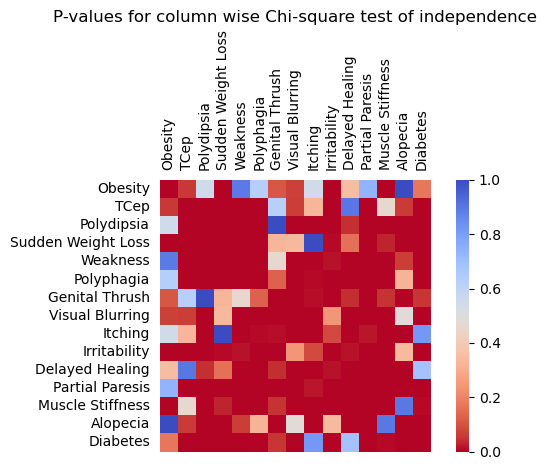

In [18]:
import matplotlib
from helpers import plot_chi_square_p_values

# reverse color as low p-value indicates strong dependence
plot_chi_square_p_values(train[binary_features + ['Diabetes']], kwargs={'cmap' : matplotlib.colormaps[cmap +'_r']})


Common sense can replace domain experts, in some cases - Roxana Pop, i.e. we should not use 'TCep' for our analysis (even though delayed healing might be correlated with aversion for tattoos)


In [19]:
from biseral_correlation import plot_point_biserial_correlation

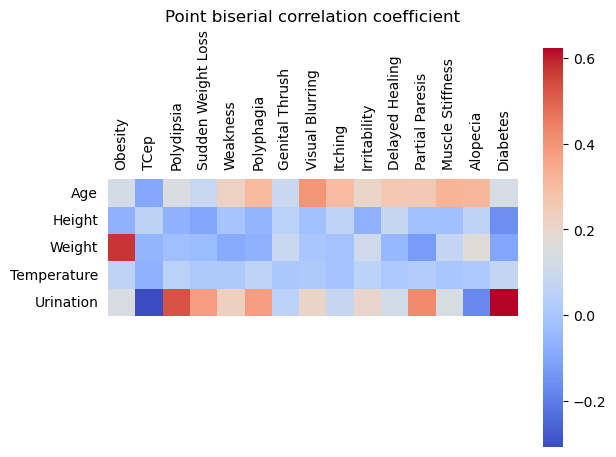

In [20]:
plot_point_biserial_correlation(train, cont=num_features, cat=binary_features + ['Diabetes'], kwargs={'cmap' : cmap})

In [21]:
from helpers import BMI

train['BMI'] = BMI(train['Weight'],  train['Height'])

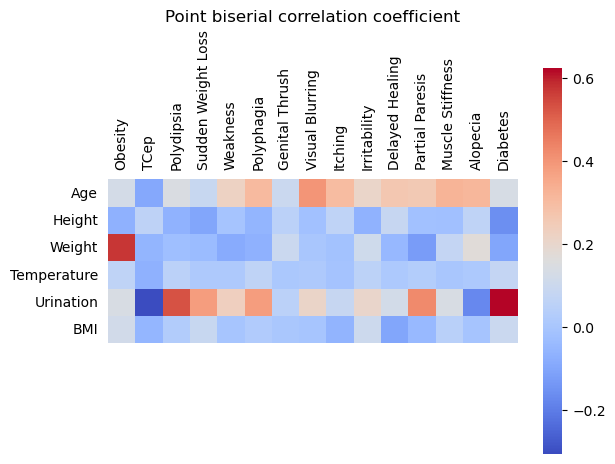

In [22]:
plot_point_biserial_correlation(train, cont=num_features + ['BMI'], cat=binary_features + ['Diabetes'], kwargs={'cmap' : cmap})

 We see that weight and obesity is strongly correlated, however BMI and obesity is not. Furthermore, diabetes has no correlation with either of them. This does not mean that BMI or weight are bad predictors, since the relationship between them could be non-linear. 

 Urination is indeed very correlated, which is apparent in the later plots.

## Data exploration

In [23]:
# There are some interesting things to see in the categoricals ...
# Only one Black in entire data set ...
# This looks very much like a rich person data set ...
for c in cat_features:
  print(train.groupby(c, dropna=False).size())

#print(train['GP'].unique())

Race
Asian        8
Black        1
MISSING      7
White      400
dtype: int64
Occupation
Architect        31
Consultant       31
Dentist          32
Economist        28
Engineer         22
Entrepreneur     22
Journalist       24
Judge            30
Lawyer           22
MISSING           7
Manager          43
Retired         123
Student           1
dtype: int64
GP
Dr. Albie Colon          25
Dr. Alice Watson         21
Dr. Andreea Gregory      24
Dr. Angharad Grainger    20
Dr. Arda O'Brien         21
Dr. Cristiano Ayala      13
Dr. Dominic Farmer       20
Dr. Ingrid Mata          20
Dr. Jamil Walters        15
Dr. Joshua Riley         21
Dr. Kameron Lancaster    25
Dr. Kason Lloyd          18
Dr. Khalid Sellers       17
Dr. Korey Clay           26
Dr. Lina Beech           16
Dr. Lorelai York         19
Dr. Madison Guy          29
Dr. Mayson Harris        22
Dr. Nial Higgs           20
Dr. Orla Arellano        20
MISSING                   4
dtype: int64


Polydipsia
0.0    1.958863
1.0    2.678781
Name: Urination, dtype: float64


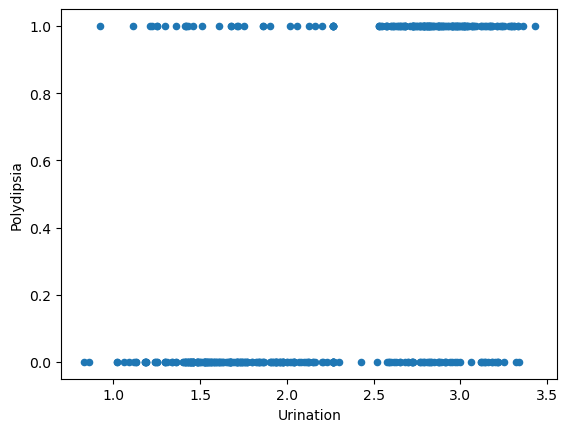

In [24]:
train.plot.scatter('Urination', 'Polydipsia')
print(train.groupby('Polydipsia')['Urination'].mean())

<Axes: ylabel='Frequency'>

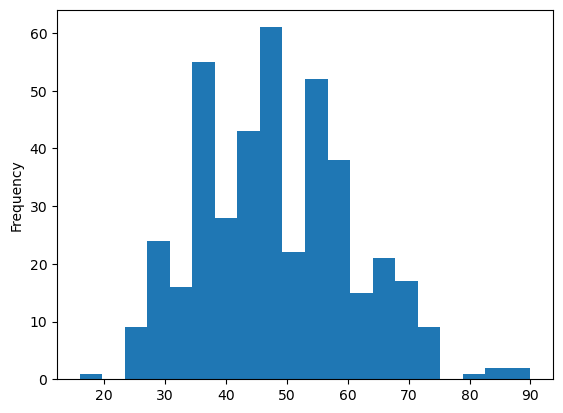

In [25]:
train['Age'].plot.hist(bins=20)

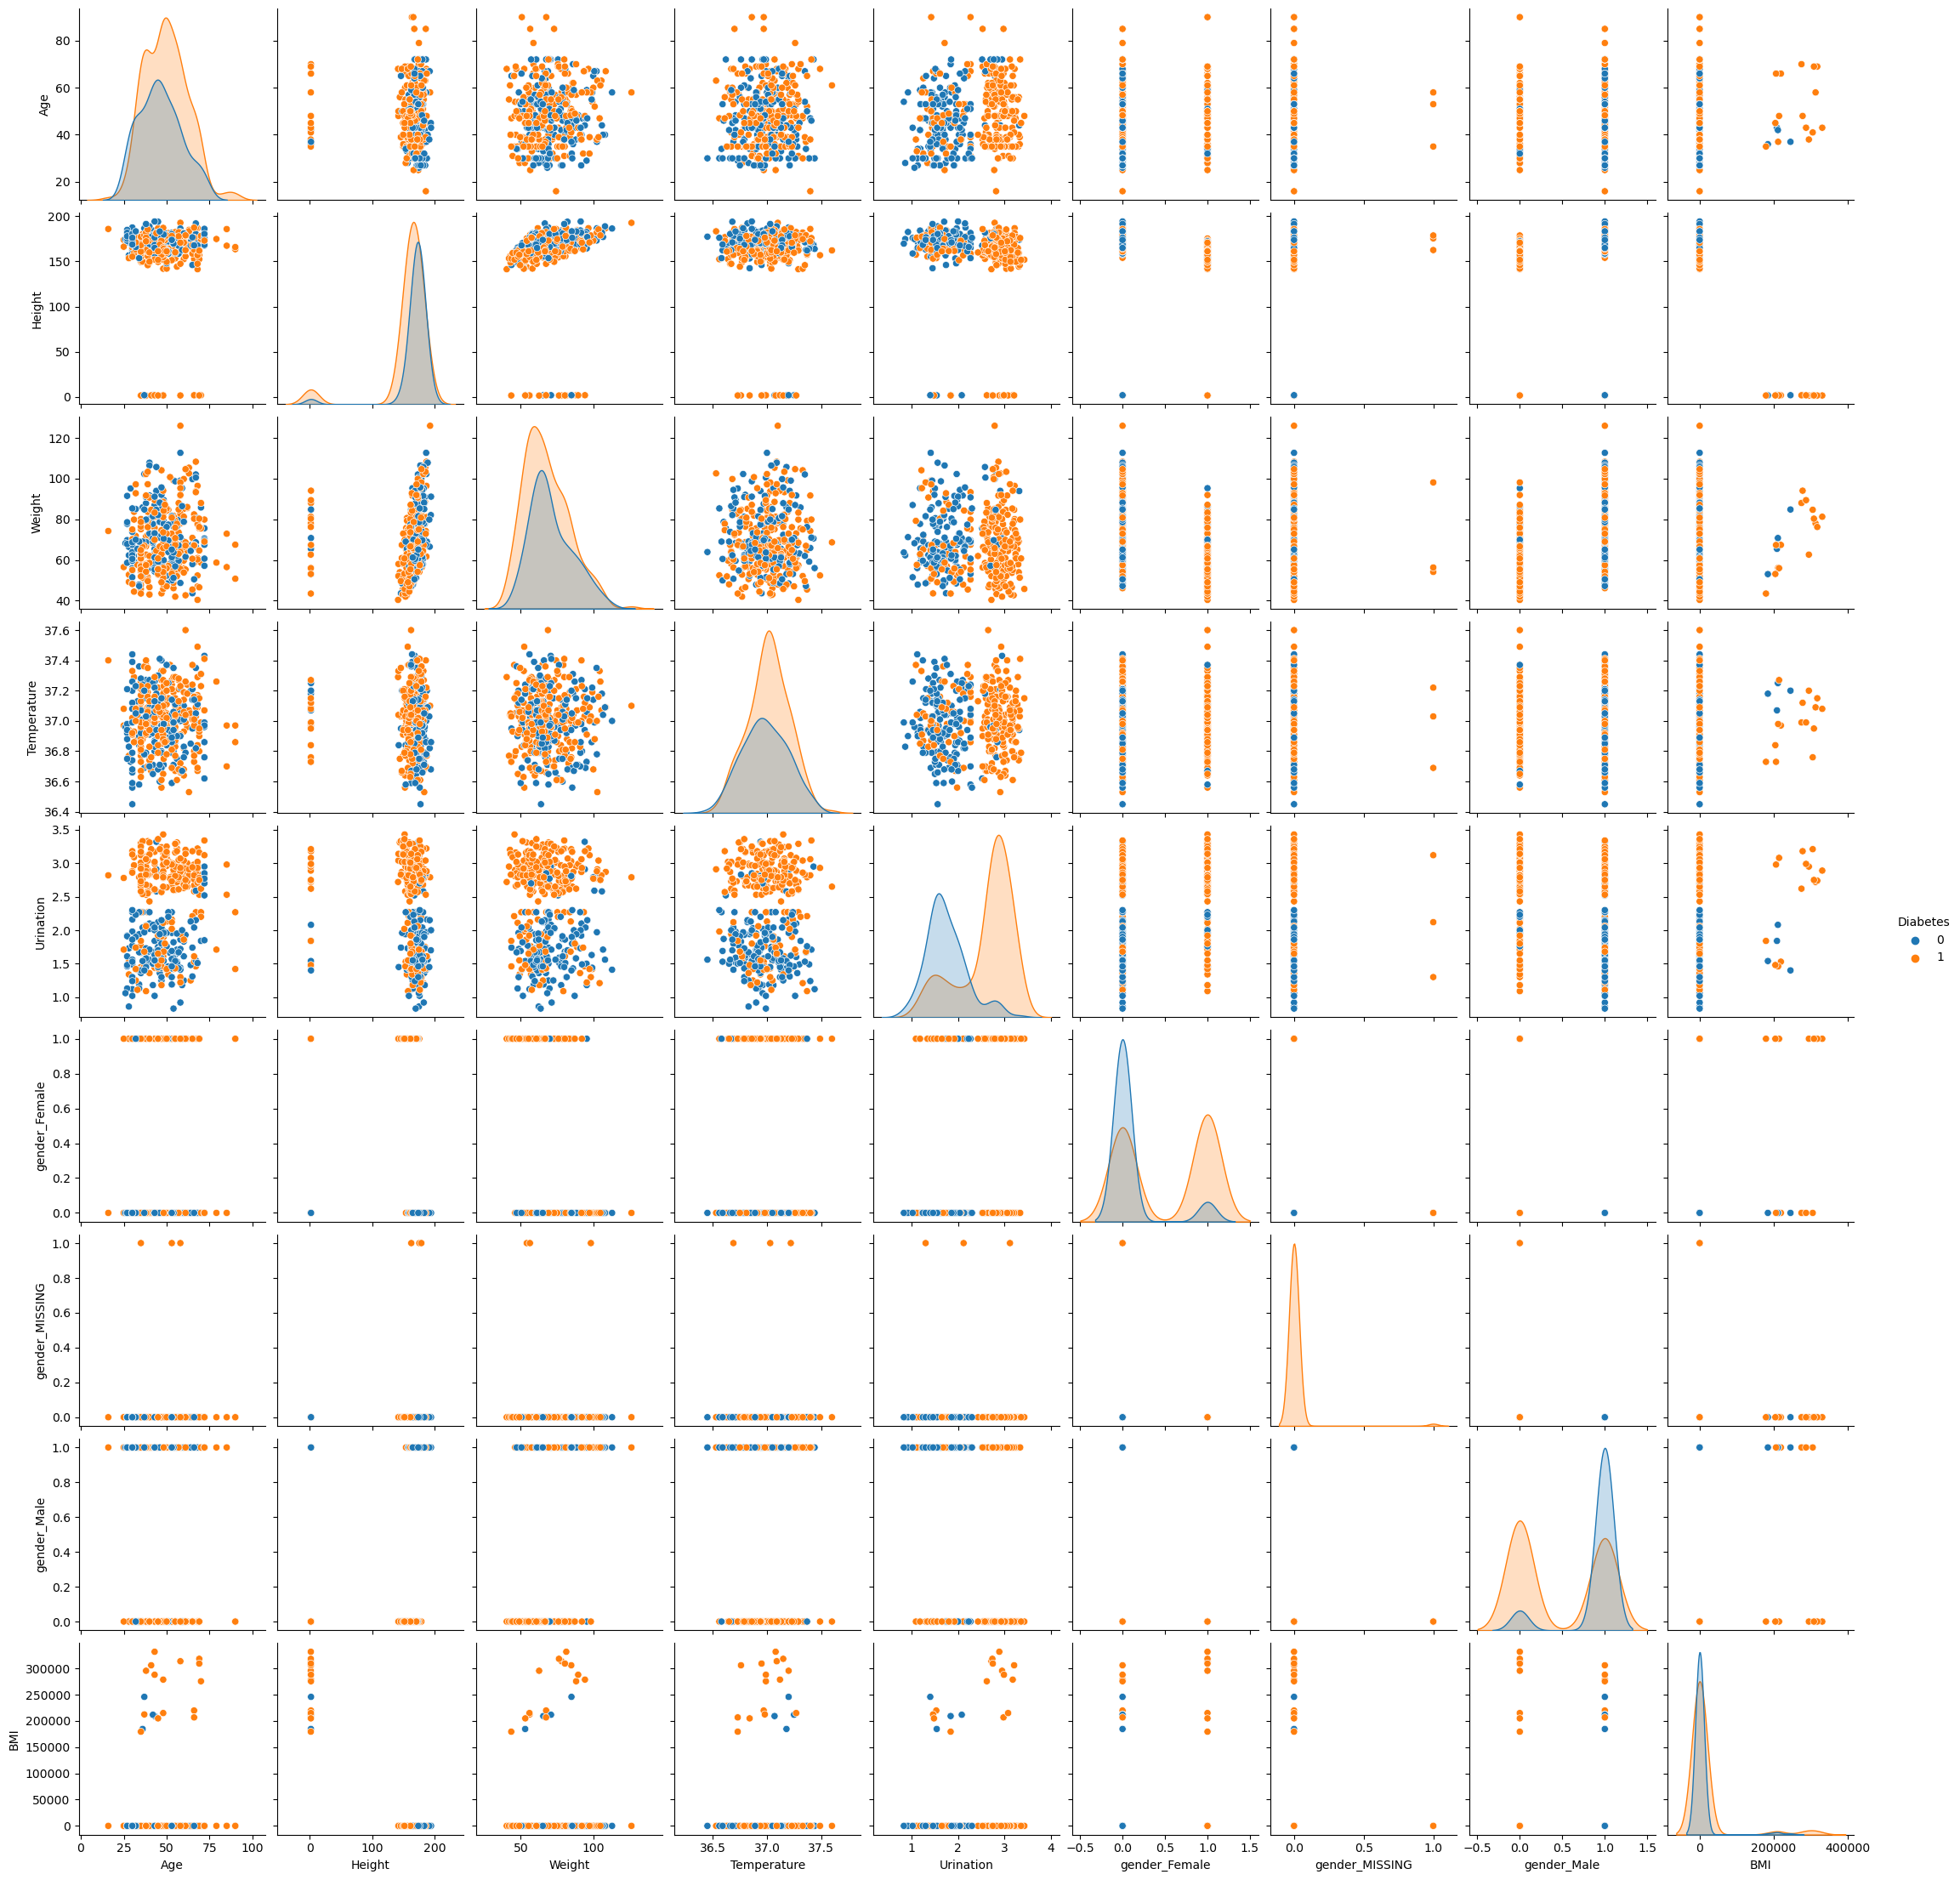

In [26]:
# After encoding, pair-plotting diabetes is messed up, because it tries to make 23*23 plots?
# need to drop the binaries from DF plotted.
train_plot = train.drop(binary_features , axis=1)

#diabetes_plot = train.drop('Gender', axis=1)
g = sns.pairplot(train_plot, hue='Diabetes')

In [27]:
#g = sns.pairplot(train_plot, kind='reg')

In [28]:
# Perhaps redundant given the chi-square plot earlier?
for f in binary_features:
  cross_tab = pd.crosstab(diabetes[f], diabetes['Diabetes'], rownames=[f], colnames=['Diabetes'])
  print(cross_tab)
  print('-----------------------')

Diabetes    0    1
Obesity           
0.0       171  264
1.0        25   53
-----------------------
Diabetes    0    1
TCep              
0          54  243
1         146   77
-----------------------
Diabetes      0    1
Polydipsia          
0.0         190   94
1.0           8  222
-----------------------
Diabetes              0    1
Sudden Weight Loss          
0.0                 169  127
1.0                  29  181
-----------------------
Diabetes    0    1
Weakness          
0.0       110  100
1.0        87  218
-----------------------
Diabetes      0    1
Polyphagia          
0.0         151  131
1.0          48  188
-----------------------
Diabetes          0    1
Genital Thrush          
0.0             163  236
1.0              31   82
-----------------------
Diabetes           0    1
Visual Blurring          
0.0              140  144
1.0               58  174
-----------------------
Diabetes    0    1
Itching           
0.0       100  165
1.0        95  154
----------------

# Training model

In [29]:
one_hot_features['Gender']

['gender_Female', 'gender_MISSING', 'gender_Male']

In [30]:
# Some sanity checks
assert train.isna().sum().sum() == 0, 'No Na-s should be present after handling. They must have been introduced'

#selected_features = ['Urination', 'Age'] + binary_features
selected_features = num_features + binary_features + one_hot_features['Gender'] 
print(selected_features)
print(len(selected_features))

# This is so stupid ... Never mind, Decision tree does not seem to care if X is series or DF ...
# Naive Bayes does, I think ...
#if len(selected_features) == 1:
#  X_train = train2[[selected_features[0]]]
#else:
X_train = train[selected_features]
y_train = train['Diabetes']

# Test set
X_test = test[selected_features]
y_test = test['Diabetes']


for index in X_train.dtypes.keys():
    dtype = X_train.dtypes[index]
    print(index, dtype)
    # Quite ugly and not very felxible test. Should be improved upon
    assert dtype == 'float64' or dtype == 'int64' or dtype == 'uint8', f"feature '{index}' is not of type float or int but {dtype}"


['Age', 'Height', 'Weight', 'Temperature', 'Urination', 'Obesity', 'TCep', 'Polydipsia', 'Sudden Weight Loss', 'Weakness', 'Polyphagia', 'Genital Thrush', 'Visual Blurring', 'Itching', 'Irritability', 'Delayed Healing', 'Partial Paresis', 'Muscle Stiffness', 'Alopecia', 'gender_Female', 'gender_MISSING', 'gender_Male']
22
Age float64
Height float64
Weight float64
Temperature float64
Urination float64
Obesity float64
TCep int64
Polydipsia float64
Sudden Weight Loss float64
Weakness float64
Polyphagia float64
Genital Thrush float64
Visual Blurring float64
Itching float64
Irritability float64
Delayed Healing float64
Partial Paresis float64
Muscle Stiffness float64
Alopecia float64
gender_Female uint8
gender_MISSING uint8
gender_Male uint8


Age : 23.40713371878214
Height : 88.6582262613058
Weight : 14.494527680794361
Temperature : 0.0026422582986043016
Urination : 32.24806309951267
Obesity : 1.9633522969612263
TCep : 58.40505117731755
Polydipsia : 97.52469412164194
Sudden Weight Loss : 46.45311275412406
Weakness : 10.072437190537318
Polyphagia : 32.85631325701013
Genital Thrush : 3.3463414634146336
Visual Blurring : 14.525502470521072
Itching : 0.05538881414273847
Irritability : 29.654444486073125
Delayed Healing : 0.139538742326199
Partial Paresis : 45.73928560303666
Muscle Stiffness : 5.7931274780728135
Alopecia : 20.053405035028817
gender_Female : 51.940110982062194
gender_MISSING : 1.9523809523809528
gender_Male : 31.27038739697554


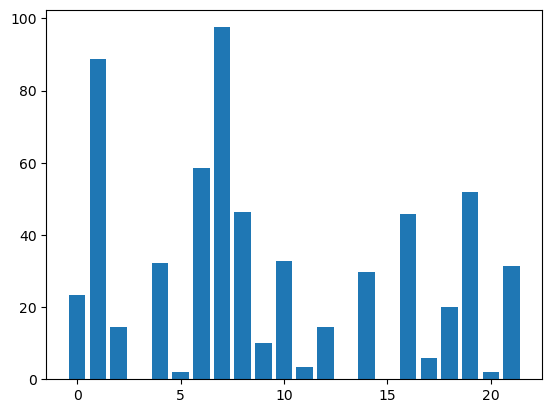

,Age,Height,Weight,Urination,TCep,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Visual Blurring,Irritability,Partial Paresis,Alopecia,gender_Female,gender_Male
252,37.0,164.070000,56.55,1.98,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
426,43.0,179.540000,56.48,1.44,0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0,1
291,45.0,162.540000,56.89,1.76,0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1,0
445,51.0,181.340000,84.61,3.03,1,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0,1
50,56.0,179.530000,63.80,1.53,0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,37.0,1.858000,84.79,1.40,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
216,58.0,170.730000,91.91,2.93,0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1,0
21,53.0,173.790000,65.11,1.46,0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0,1
251,45.0,161.207421,55.37,1.65,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,0


In [31]:
from sklearn.feature_selection import SelectKBest, chi2
skb =  SelectKBest(chi2, k=15)
X_new = skb.fit_transform(X_train, y_train)

cols_idxs = skb.get_support(indices=True)
features_df_new = X_train.iloc[:,cols_idxs]



# what are scores for the features
for i in range(len(skb.scores_)):
 print(X_train.columns[i], ":", skb.scores_[i])
# plot the scores
plt.bar([i for i in range(len(skb.scores_))], skb.scores_)
plt.show()
features_df_new

Decision tree with depth=1. cv score: 0.7932587492828458
Decision tree with depth=2. cv score: 0.8341652323580033
Decision tree with depth=3. cv score: 0.8677280550774527
Decision tree with depth=4. cv score: 0.8750430292598967
Decision tree with depth=5. cv score: 0.9014629948364888
Decision tree with depth=6. cv score: 0.8966150315547905
Decision tree with depth=7. cv score: 0.8917957544463568
Decision tree with depth=8. cv score: 0.891853126792886
Decision tree with depth=9. cv score: 0.8989959839357429
Decision tree with depth=10. cv score: 0.8894148020654045
Decision tree with depth=11. cv score: 0.906253585771658
Decision tree with depth=12. cv score: 0.8798049340218015
Decision tree with depth=13. cv score: 0.8845668387837063
Decision tree with depth=14. cv score: 0.8797762478485371
Decision tree with depth=15. cv score: 0.8965863453815259
Decision tree with depth=16. cv score: 0.8917670682730924
Decision tree with depth=17. cv score: 0.8869477911646587
Decision tree with depth=

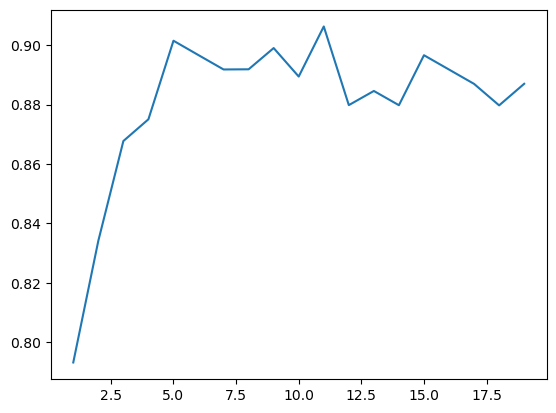

In [32]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

depths = list(range(1, 20))

scores = {}

"""
By weighing misslcassification more severly, we can minimze type II error,
which is desirable in the public health scenario. However, even with
a very skewed weighing (1-100), we still get missclassification,
indicatting that there are 'outliers' in the test set.

Further investigation revealed that they typically where quite old or quite young,
with a typical amount of urination.
"""
weight = {0: 1,
          1:1}

use_weights = False

for d in depths:
    clf_cv = tree.DecisionTreeClassifier(max_depth=d, class_weight=weight if use_weights else None)
    score = cross_val_score(clf_cv, X_train, y_train, cv=5).mean()
    scores[d] = score
    print(f'Decision tree with depth={d}. cv score: {score}')

print(scores.values())

plt.plot(scores.keys(), scores.values())

clf = tree.DecisionTreeClassifier(max_depth=7, class_weight=weight if use_weights else None)
clf = clf.fit(X_train, y_train)

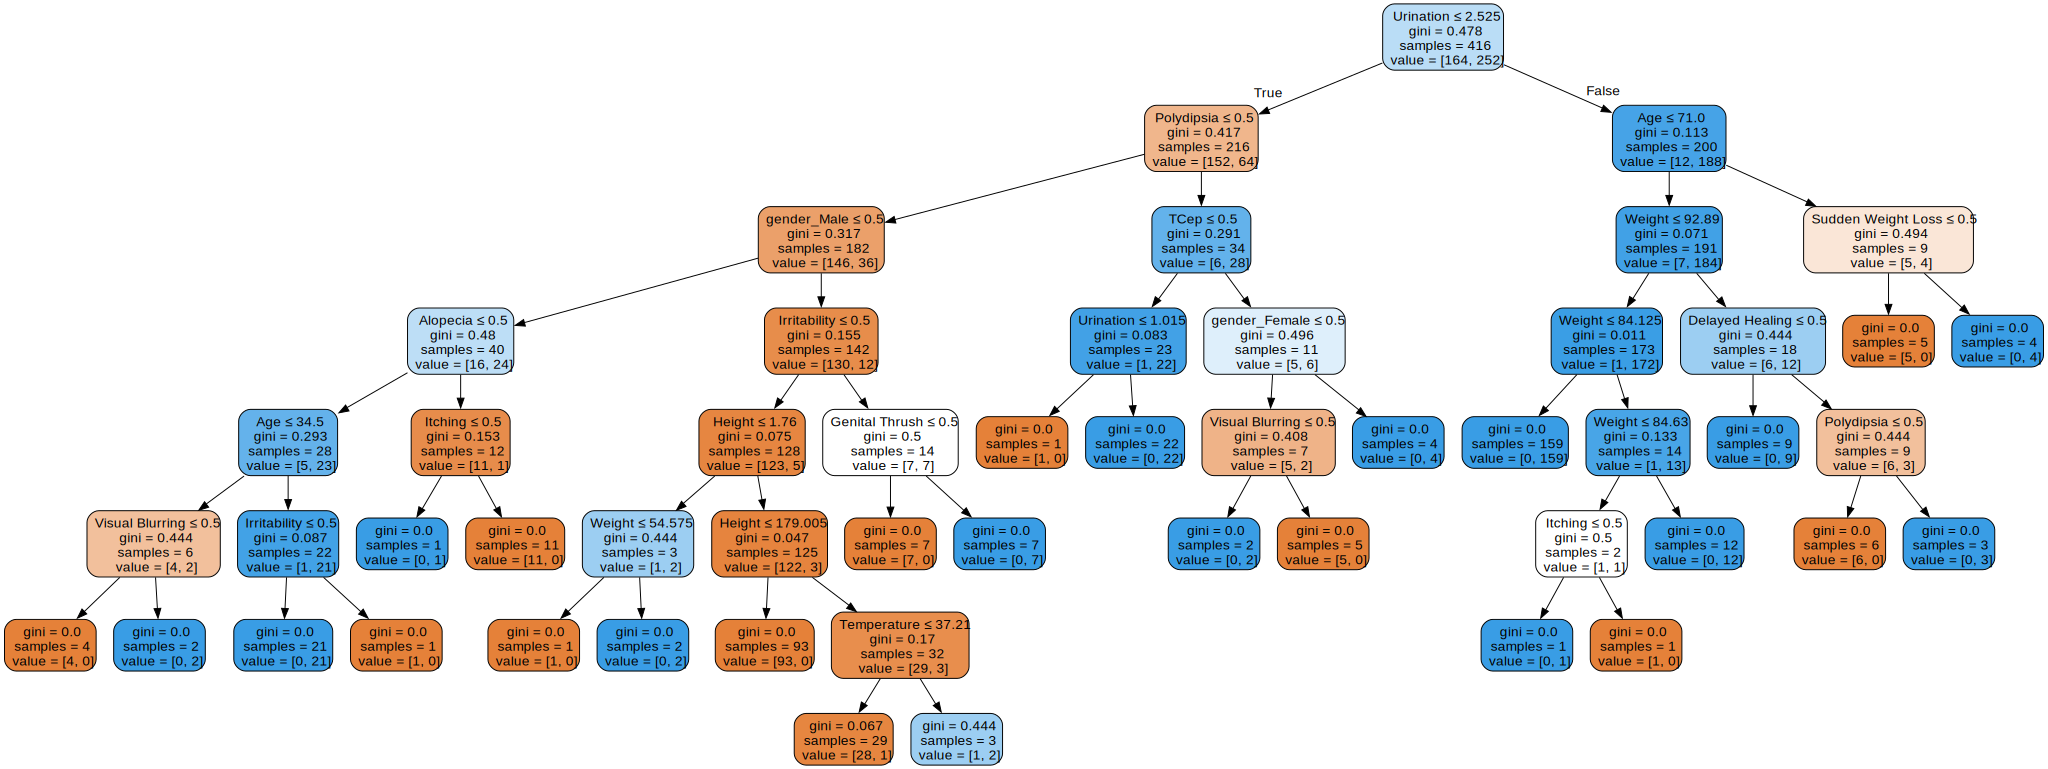

In [33]:
import graphviz

dot_data = tree.export_graphviz(clf, out_file=None,
                      feature_names=selected_features,
                      #class_names='Diabetes', # this parameter doesen't seem to work
                      filled=True, rounded=True,
                      special_characters=True)
graph = graphviz.Source(dot_data)
# Make Pdf
#graph.render("Diabetes")
graph

In [34]:
# Training accuracy
from sklearn import metrics
y_train_pred = clf.predict(X_train)
metrics.accuracy_score(y_train, y_train_pred)

0.9951923076923077

In [35]:
y_test_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_test_pred)

0.9423076923076923

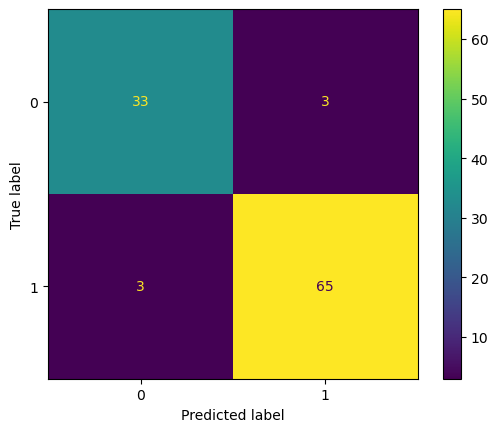

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay

confusion_mat = metrics.confusion_matrix(y_test, y_test_pred)
con_mat_disp = ConfusionMatrixDisplay(confusion_mat, display_labels=clf.classes_)
con_mat_disp.plot()

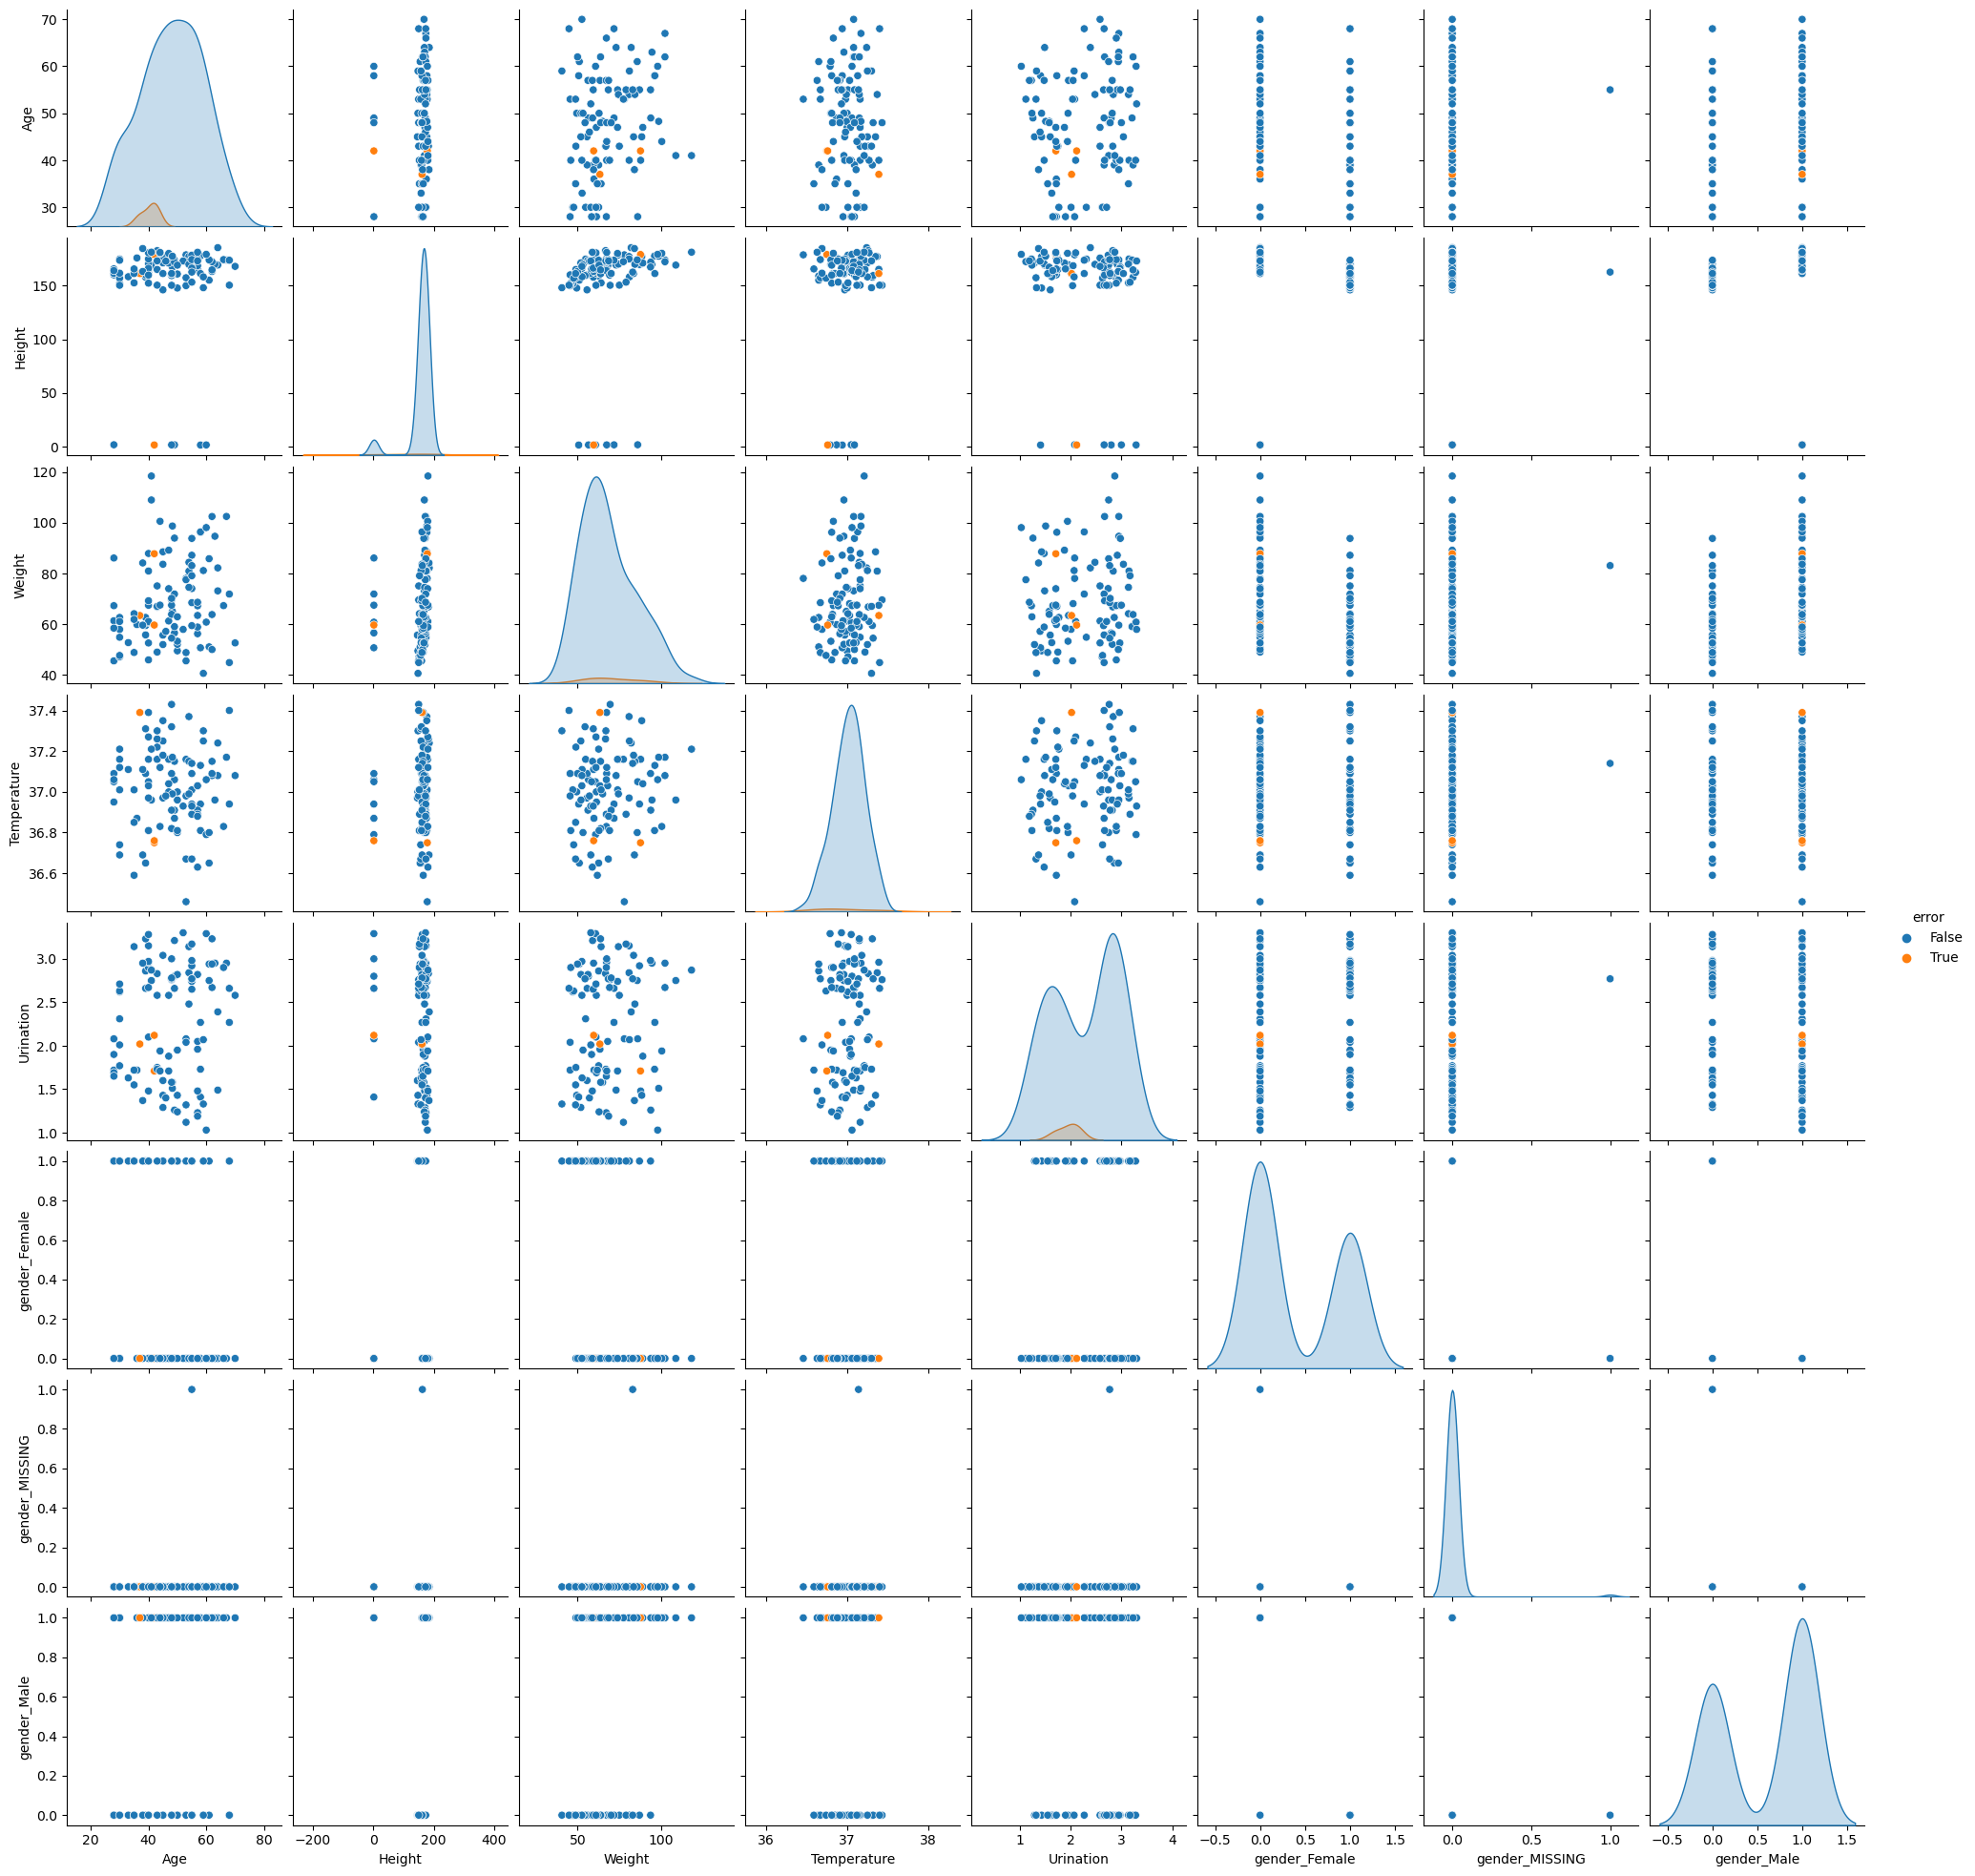

In [37]:
X_test_plot = X_test.copy()
X_test_plot['error'] = y_test > y_test_pred
g = sns.pairplot(X_test_plot.drop(binary_features, axis=1), hue='error')

Logistic regression with C = 10.00. cv score: 0.908720596672404
Logistic regression with C = 7.85. cv score: 0.908720596672404
Logistic regression with C = 6.16. cv score: 0.908720596672404
Logistic regression with C = 4.83. cv score: 0.908720596672404
Logistic regression with C = 3.79. cv score: 0.9135398737808377
Logistic regression with C = 2.98. cv score: 0.9135398737808377
Logistic regression with C = 2.34. cv score: 0.9135398737808377
Logistic regression with C = 1.83. cv score: 0.9111589213998853
Logistic regression with C = 1.44. cv score: 0.9135972461273667
Logistic regression with C = 1.13. cv score: 0.9135972461273667
Logistic regression with C = 0.89. cv score: 0.9160068846815836
Logistic regression with C = 0.70. cv score: 0.9160068846815836
Logistic regression with C = 0.55. cv score: 0.9111876075731498
Logistic regression with C = 0.43. cv score: 0.9111876075731498
Logistic regression with C = 0.34. cv score: 0.9087779690189329
Logistic regression with C = 0.26. cv score

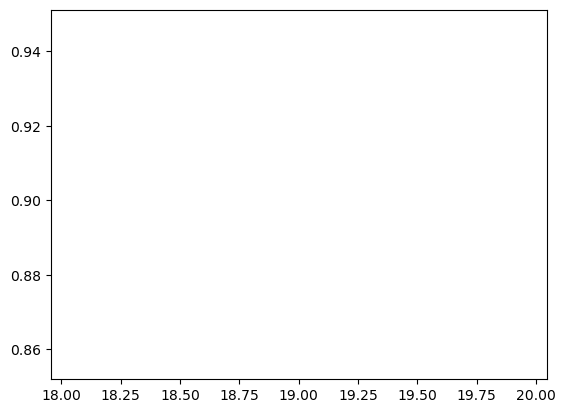

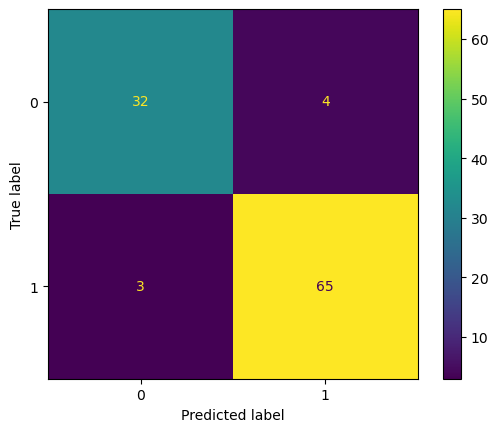

In [38]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1', solver='liblinear', C=1000)

cs = 1/np.geomspace(0.1, 10, 20)

scores = {}


for c in cs:
    clf_cv = LogisticRegression(penalty='l2', solver='liblinear', C=c)
    score = cross_val_score(clf_cv, X_train, y_train, cv=5).mean()
    scores[d] = score
    print(f'Logistic regression with C = {c:.2f}. cv score: {score}')

print(scores.values())

plt.plot(scores.keys(), scores.values())



clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)

# Accuracy
print(metrics.accuracy_score(y_test, y_test_pred))
print(clf.coef_)

# Confusion Matrix
confusion_mat = metrics.confusion_matrix(y_test, y_test_pred)
con_mat_disp = ConfusionMatrixDisplay(confusion_mat, display_labels=clf.classes_)
con_mat_disp.plot()


In [39]:
metrics.accuracy_score(y_test, y_test_pred)

0.9326923076923077